In [1]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.mixture import GaussianMixture

In [2]:
# Caminhos
raster_path = '../LiDAR_produtos/2017/BHM-2017-50cm.tiff'   # raster

# Carregar feições
gdf = gpd.read_file('data/SIRGAS_GPKG_favela.gpkg')
gdf.geometry = gdf.buffer(0)

/Users/fernandogomes/miniconda3/envs/geo/lib/python3.12/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D Polygon' is converted to 'Polygon Z'
  return ogr_read(


In [3]:
gdf.columns

Index(['fv_nome', 'fv_data', 'fv_nom_sec', 'fv_tp_prop', 'fv_domicil',
       'geometry'],
      dtype='object')

In [4]:
# Selecionar a feição (exemplo: primeira)
favela_geom = gdf.loc[gdf.fv_nome == 'São Remo', :].geometry.values.tolist()

## TODO
# Separar as favelas que o Bruno está testando
favelas_test = [
    "Heliópolis",
    "Cocaia I",
    "Paraisópolis",
    "Futuro Melhor",
    "São Remo"
]

In [5]:
# Supondo que você tenha um DataFrame gdf com a coluna 'fv_nome'
favelas_filtradas = gdf[gdf['fv_nome'].isin(favelas_test)]

In [6]:
favelas_filtradas.dissolve(by='fv_nome').reset_index()

,fv_nome,geometry,fv_data,fv_nom_sec,fv_tp_prop,fv_domicil
0,Cocaia I,"POLYGON ((3.29e+05 7.37e+06, 3.29e+05 7.37e+06...",2016-04-20,-,1,618
1,Futuro Melhor,"POLYGON ((3.3e+05 7.41e+06, 3.3e+05 7.41e+06, ...",2016-04-12,Peri Alto,1,1500
2,Heliópolis,"MULTIPOLYGON (((3.37e+05 7.39e+06, 3.37e+05 7....",2016-04-04,-,1,15843
3,Paraisópolis,"POLYGON ((3.23e+05 7.39e+06, 3.23e+05 7.39e+06...",2016-04-18,-,1,17159
4,São Remo,"POLYGON ((3.22e+05 7.39e+06, 3.22e+05 7.39e+06...",2017-08-03,-,1,2000


In [7]:
# Abrir raster e recortar pela feição
with rasterio.open(raster_path) as src:
    print("Raster CRS:", src.crs)
    print("Bounds do raster:", src.bounds)
    print("Bounds da favela 0:", gdf.loc[gdf.fv_nome == 'São Remo', :].geometry.bounds)
    out_image, out_transform = mask(src, favela_geom, crop=True)
    out_data = out_image[0]

    # Filtrar valores válidos
    valid_data = out_data[out_data != src.nodata]

# Ordenar os valores
sorted_data = np.sort(valid_data)



Raster CRS: EPSG:31983
Bounds do raster: BoundingBox(left=313179.5, bottom=7343480.5, right=360683.0, top=7416432.5)
Bounds da favela 0:               minx          miny           maxx          maxy
668  321740.305639  7.392975e+06  322166.723848  7.393369e+06


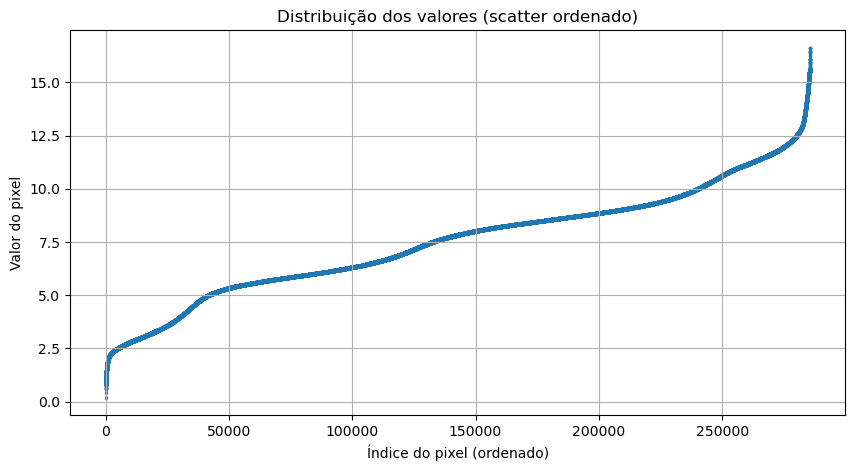

In [8]:
# Scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(range(len(sorted_data)), sorted_data, s=2, alpha=0.6)
plt.xlabel("Índice do pixel (ordenado)")
plt.ylabel("Valor do pixel")
plt.title("Distribuição dos valores (scatter ordenado)")
plt.grid(True)
plt.show()

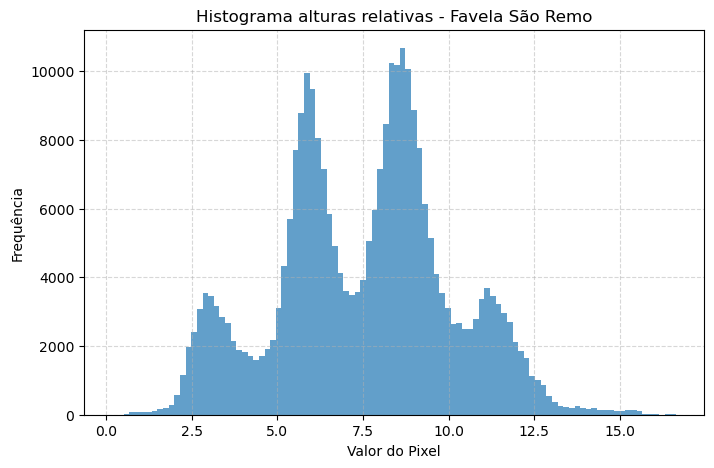

In [20]:
# Definir número de bins (intervalos)
bins = 100  # você pode ajustar conforme necessário

# Calcular histograma
hist, bin_edges = np.histogram(sorted_data, bins=bins)

# Plotar
plt.figure(figsize=(8, 5))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align='edge', alpha=0.7)
plt.xlabel("Valor do Pixel")
plt.ylabel("Frequência")
plt.title("Histograma alturas relativas - Favela São Remo")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Picos detectados: [16 34 51 66]
Número de picos: 4


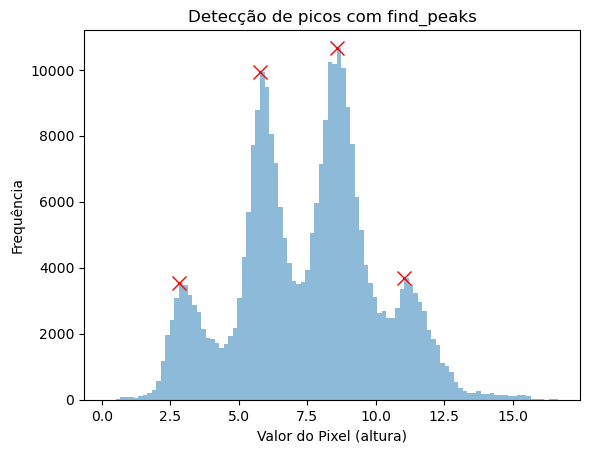

In [10]:
# Detectar picos
peaks, properties = find_peaks(hist, prominence=500, distance=3)

# Mostrar número de picos
print("Picos detectados:", peaks)
print("Número de picos:", len(peaks))

# Plot para visualizar
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), alpha=0.5, align='edge')
plt.plot(bin_edges[peaks], hist[peaks], "x", color="red", markersize=10)  # marcar picos
plt.title("Detecção de picos com find_peaks")
plt.xlabel("Valor do Pixel (altura)")
plt.ylabel("Frequência")
plt.show()

In [11]:
properties

{'prominences': array([ 1970.,  6437., 10663.,  1203.]),
 'left_bases': array([ 1,  1,  1, 62]),
 'right_bases': array([25, 42, 97, 97])}

Número de picos detectados: 4
Alturas médias por tipologia (μ): [ 3.22622095  5.96502743  8.56515727 11.20788429]
Desvios padrão (σ): [0.65548844 0.71150833 0.71361393 1.21907106]
Altura média de pavimento estimada: 2.6605544458604196


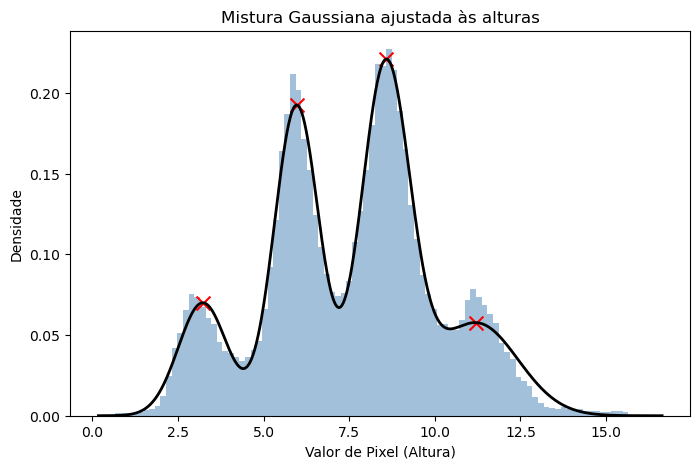

In [12]:
# === 2. Detectar picos ===
peaks, _ = find_peaks(hist, prominence=500, distance=3)
k = len(peaks)  # número de componentes para o GMM
print(f"Número de picos detectados: {k}")

# === 3. Rodar GMM ===
data = np.array(sorted_data).reshape(-1, 1)  # dados no formato (N, 1)
gmm = GaussianMixture(n_components=k, random_state=0).fit(data)

# Médias e desvios das distribuições
mus = np.sort(gmm.means_.flatten())
sigmas = np.sqrt(np.sort(gmm.covariances_.flatten()))

print("Alturas médias por tipologia (μ):", mus)
print("Desvios padrão (σ):", sigmas)

# Altura média de pavimento (diferença média entre os picos)
h_pav = np.mean(np.diff(mus))
print("Altura média de pavimento estimada:", h_pav)

# === 4. Visualização ===
x = np.linspace(min(sorted_data), max(sorted_data), 1000).reshape(-1, 1)
densidade = np.exp(gmm.score_samples(x))

plt.figure(figsize=(8,5))
plt.hist(sorted_data, bins=bins, density=True, alpha=0.5, color='steelblue')
plt.plot(x, densidade, '-k', lw=2)
plt.scatter(mus, np.exp(gmm.score_samples(mus.reshape(-1,1))), c='red', marker='x', s=100)
plt.title("Mistura Gaussiana ajustada às alturas")
plt.xlabel("Valor de Pixel (Altura)")
plt.ylabel("Densidade")
plt.show()

In [13]:
h = np.array([[7.0]])  # altura exemplo
probs = gmm.predict_proba(h)
print("Probabilidades por classe:", probs)
classe = np.argmax(probs)
print(f"Altura {h[0][0]} m pertence à classe {classe} com μ={mus[classe]:.2f} m")

Probabilidades por classe: [[2.56929606e-01 7.41075740e-01 1.99386087e-03 7.93584199e-07]]
Altura 7.0 m pertence à classe 1 com μ=5.97 m


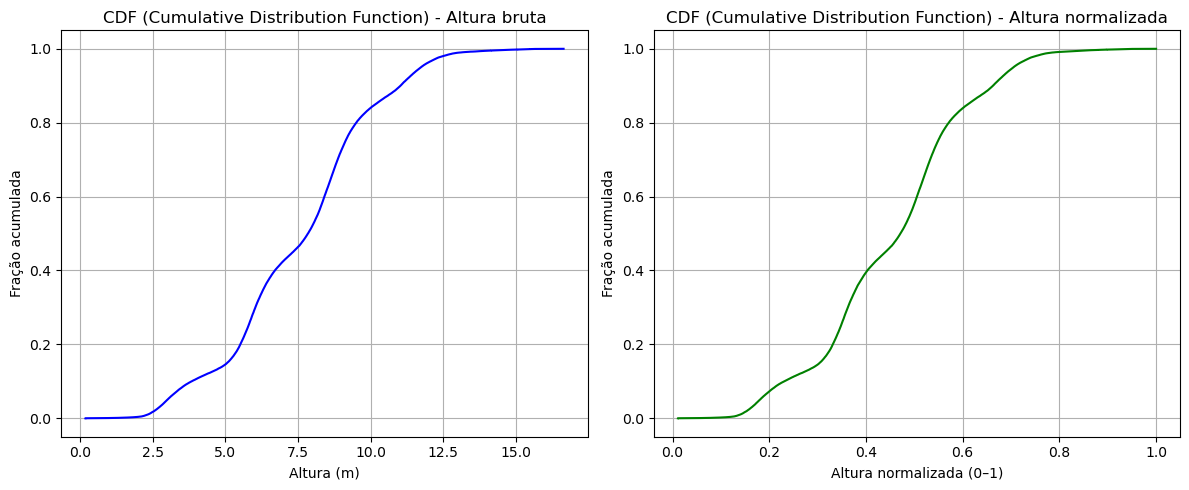

In [22]:
# 2. Calcular CDF empírica (valores brutos)
cdf_empirica = np.arange(1, len(sorted_data)+1) / len(sorted_data)

# 3. Calcular CDF com dados normalizados
sorted_data_norm = sorted_data / sorted_data.max()
cdf_norm = np.arange(1, len(sorted_data_norm)+1) / len(sorted_data_norm)

# 4. Plotar as duas CDFs lado a lado
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sorted_data, cdf_empirica, color='blue', label='CDF bruta')
plt.xlabel("Altura (m)")
plt.ylabel("Fração acumulada")
plt.title("CDF (Cumulative Distribution Function) - Altura bruta")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(sorted_data_norm, cdf_norm, color='green', label='CDF normalizada')
plt.xlabel("Altura normalizada (0–1)")
plt.ylabel("Fração acumulada")
plt.title("CDF (Cumulative Distribution Function) - Altura normalizada")
plt.grid(True)

plt.tight_layout()
plt.show()

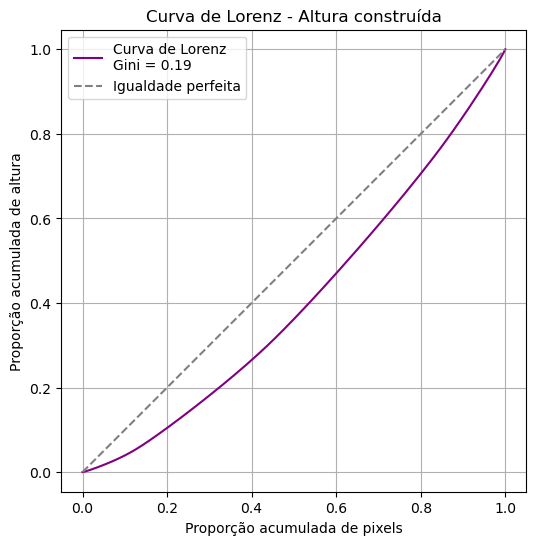

In [15]:
def curva_lorenz(valores):
    """Retorna a curva de Lorenz e o índice de Gini"""
    sorted_vals = np.sort(valores)
    n = len(sorted_vals)
    cumulative_vals = np.cumsum(sorted_vals)
    cumulative_vals = cumulative_vals / cumulative_vals[-1]  # normaliza para [0,1]
    
    cumulative_population = np.arange(1, n+1) / n
    cumulative_population = np.insert(cumulative_population, 0, 0)
    cumulative_vals = np.insert(cumulative_vals, 0, 0)

    # Cálculo do índice de Gini (área entre linha da igualdade e curva)
    B = np.trapz(cumulative_vals, cumulative_population)
    A = 0.5 - B
    gini = A / (A + B)
    
    return cumulative_population, cumulative_vals, gini

# Aplicar aos seus dados válidos (valores de altura do raster)
x, y, gini = curva_lorenz(sorted_data)

# Plotar a curva
plt.figure(figsize=(6,6))
plt.plot(x, y, label=f'Curva de Lorenz\nGini = {gini:.2f}', color='purple')
plt.plot([0,1], [0,1], '--', color='gray', label='Igualdade perfeita')
plt.xlabel('Proporção acumulada de pixels')
plt.ylabel('Proporção acumulada de altura')
plt.title('Curva de Lorenz - Altura construída')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()